## Creative Content Assisted by Generative AI using Titan Image Generator: Outpainting

In this notebook, we demonstrate an approach to modify images called outpainting. Outpainting is a process used to extend images based on a textual prompt. We will accomplish this using Titan Image Generator from Amazon Bedrock.


### Setup

Add the import statements and helper functions for coverting images

In [9]:
import os
import boto3
import json
import base64
from PIL import Image
from io import BytesIO
from random import randint


#Get an inpainting or outpainting mask for the provided dimensions
def get_mask_image_base64(target_width, target_height, position, inside_width, inside_height):
    
    inside_color_value = (0, 0, 0) #inside is black - this is the masked area
    outside_color_value = (255, 255, 255)
    
    mask_image = Image.new("RGB", (target_width, target_height), outside_color_value)
    original_image_shape = Image.new(
        "RGB", (inside_width, inside_height), inside_color_value
    )
    mask_image.paste(original_image_shape, position)
    mask_image_base64 = get_png_base64(mask_image)
    
    mask_image.save("mask.png") #uncomment this to see what the mask looks like

    return mask_image_base64

#get a BytesIO object from file bytes
def get_bytesio_from_bytes(image_bytes):
    image_io = BytesIO(image_bytes)
    return image_io


#get a base64-encoded PNG image from an Image object
def get_png_base64(image):
    png_io = BytesIO()
    image.save(png_io, format="PNG")
    img_str = base64.b64encode(png_io.getvalue()).decode("utf-8")
    return img_str


#get an Image object from file bytes
def get_image_from_bytes(image_bytes):
    
    image_io = BytesIO(image_bytes)
    
    image = Image.open(image_io)
    
    return image


#load the bytes from a file on disk
def get_bytes_from_file(file_path):
    with open(file_path, "rb") as image_file:
        file_bytes = image_file.read()
    return file_bytes
    



### Helper function to prepare the request payload for submission to Bedrock

In [10]:
#get the stringified request body for the InvokeModel API call
def get_titan_image_extension_request_body(prompt, input_image_bytes, negative_prompt=None, vertical_alignment=0.5, horizontal_alignment=0.5):

    # Create an input image which contains the original image with an extended canvas
    original_image = get_image_from_bytes(input_image_bytes)
    
    original_width, original_height = original_image.size
    
    target_width = 1024 #extended canvas size
    target_height = 1024
    
    position = ( #position the existing image within the larger canvas, based on the selected alignment
        int((target_width - original_width) * horizontal_alignment), 
        int((target_height - original_height) * vertical_alignment),
    )
    
    #######
    extended_image = Image.new("RGB", (target_width, target_height), (235, 235, 235))
    extended_image.paste(original_image, position)
    extended_image_base64 = get_png_base64(extended_image)
    
    #######
    mask_image_base64 = get_mask_image_base64(target_width, target_height, position, original_width, original_height)
    
    body = { #create the JSON payload to pass to the InvokeModel API
        "taskType": "OUTPAINTING",
        "outPaintingParams": {
            "image": extended_image_base64,
            "maskImage": mask_image_base64,
            "text": prompt,  # Description of the background to generate
            "outPaintingMode": "DEFAULT",  # "DEFAULT" softens the mask. "PRECISE" keeps it sharp.
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,  # Number of variations to generate
            "quality": "premium",  # Allowed values are "standard" or "premium"
            "width": target_width,
            "height": target_height,
            "cfgScale": 8,
            "seed": randint(0, 100000),  # Use a random seed
        },
    }
    
    if negative_prompt:
        body['outPaintingParams']['negativeText'] = negative_prompt
    
    return json.dumps(body)

### Helper functions to call Bedrock and extract image from the response


In [11]:
#get a BytesIO object from the Titan Image Generator response
def get_titan_response_image(response):

    response = json.loads(response.get('body').read())
    
    images = response.get('images')
    
    image_data = base64.b64decode(images[0])

    return BytesIO(image_data)


#generate an image using Amazon Titan Image Generator
def get_image_from_model(prompt_content, image_bytes, negative_prompt=None, vertical_alignment=0.5, horizontal_alignment=0.5):
    session = boto3.Session(
        profile_name=os.environ.get("BWB_PROFILE_NAME")
    ) #sets the profile name to use for AWS credentials
    
    bedrock = session.client(
        service_name='bedrock-runtime', #creates a Bedrock client
        region_name=os.environ.get("BWB_REGION_NAME"),
        endpoint_url=os.environ.get("BWB_ENDPOINT_URL")
    ) 
    
    body = get_titan_image_extension_request_body(prompt_content, image_bytes, negative_prompt=negative_prompt, vertical_alignment=vertical_alignment, horizontal_alignment=horizontal_alignment)
    
    response = bedrock.invoke_model(body=body, modelId="amazon.titan-image-generator-v1", contentType="application/json", accept="application/json")
    
    output = get_titan_response_image(response)
    
    return output

### Pass the image to the helper functions with the textual prompt for outpainting the image

Original Image


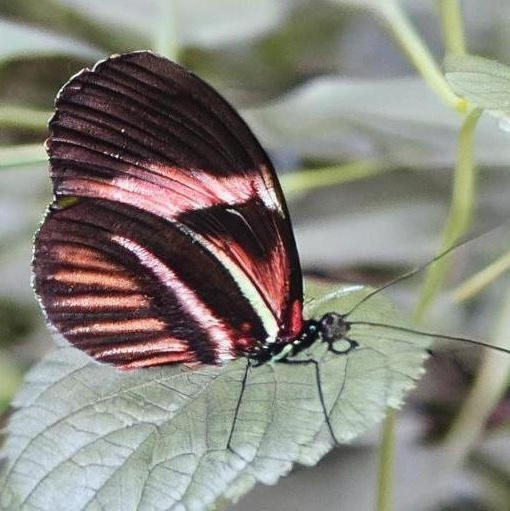

Extended Image


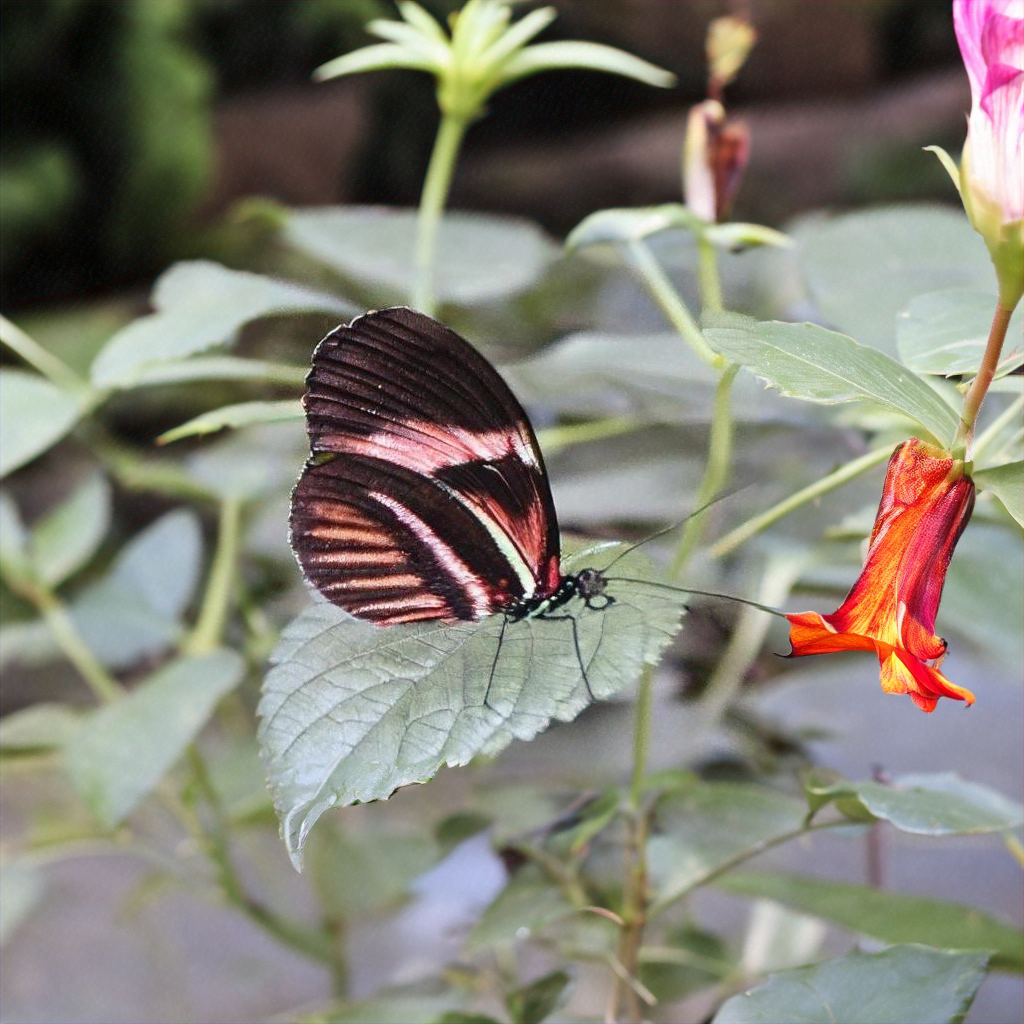

In [15]:

img_file='data/butterfly.jpg'
original_image = Image.open(img_file)

print("Original Image")
display(original_image)



with open(img_file, "rb") as image_file:
        input_image = image_file.read()


image_bytes = get_image_from_model("garden landscape", input_image)


print("Extended Image")
image = Image.open(image_bytes)
display(image)

